In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\TYC\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\TYC\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
100%|██████████| 1000/1000 [02:17<00:00,  7.29it/s]


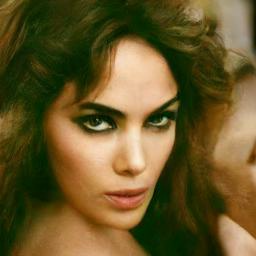

In [ ]:
#from an existing pipeline
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

images = image_pipe().images
images[0]

In [4]:
#DDIM scheduler needs less step than DDPM
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

0it [00:00, ?it/s]

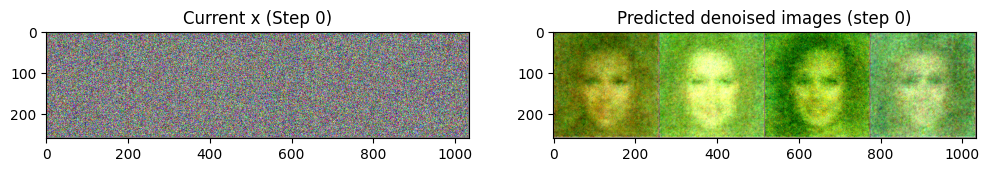

10it [00:05,  2.01it/s]

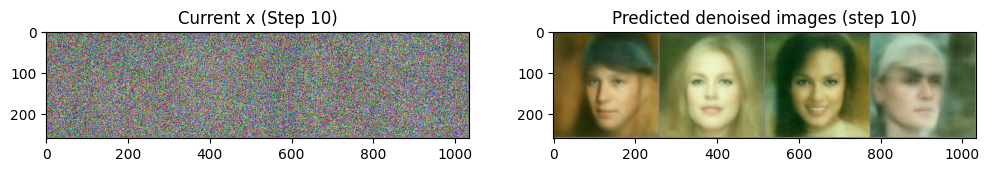

20it [00:10,  1.99it/s]

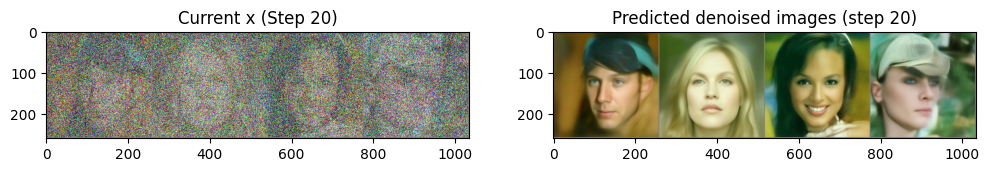

30it [00:15,  1.99it/s]

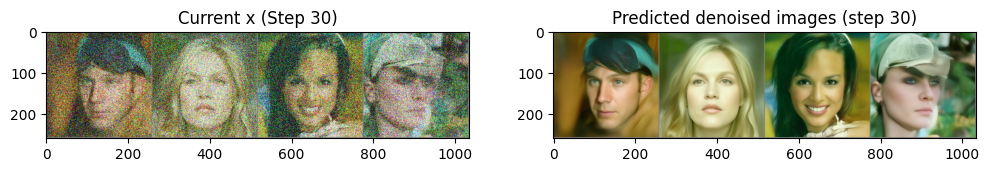

39it [00:20,  1.98it/s]

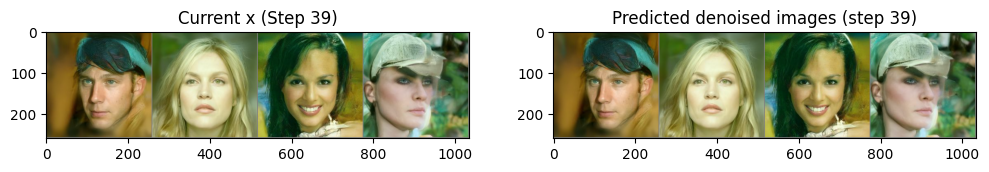

40it [00:21,  1.88it/s]


In [21]:
#create random noise as starting point
x =torch.randn(4, 3, 256, 256).to(device) # 4 images RGB

#sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):

    #model input
    model_input = scheduler.scale_model_input(x, t)

    #prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    #calculate what the updated sample should look like with scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    #update x
    x = scheduler_output.prev_sample

    #display x and predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (Step {i})")

        pred_x0 = scheduler_output.pred_original_sample
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


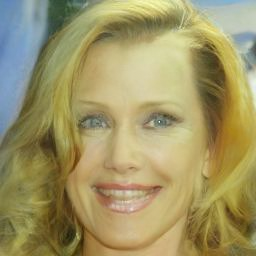

In [5]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

In [30]:
#finetune with butterflies .__.
dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")
image_size = 256
batch_size = 4

#image preprocessing
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
dataset.shape

Repo card metadata block was not found. Setting CardData to empty.


(1000, 18)

In [31]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

Previewing batch: 


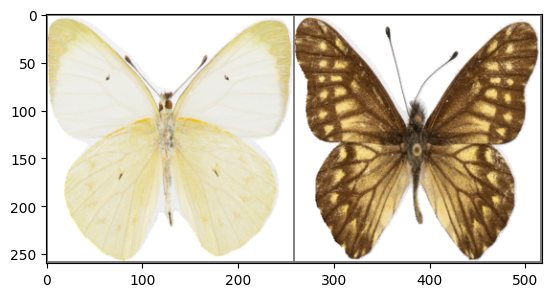

In [32]:
dataset.set_transform(transform)

batch_size = 2 #small batch size to save gpu memory
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Previewing batch: ")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


1000


100%|██████████| 500/500 [1:27:29<00:00, 10.50s/it]

Epoch 0 average loss: 0.01453244700138748


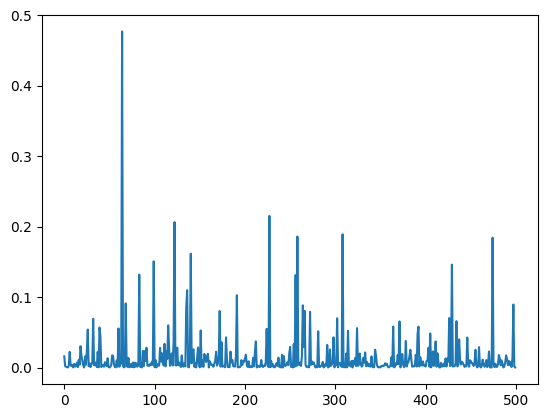

In [33]:
num_epochs = 1 #my computer too weak
lr = 1e-5
grad_accumulation_steps = 8 #my gpu too small

#check timestep
print(image_pipe.scheduler.num_train_timesteps)

#optimizer
optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

#record losses
losses = []

#training loop
for epoch in range(num_epochs):

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        clean_images = batch["images"].to(device)

        #sample noise to add to images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        #sample random timesteps for each image
        timesteps = torch.randint(0, image_pipe.scheduler.num_train_timesteps, (bs, ), device=clean_images.device).long()

        #add noise
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        #get prediction
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        #compare with actual noise
        loss = F.mse_loss(noise_pred, noise) #predict epsilon, not noisyimage - cleanimage !!!

        #record loss
        losses.append(loss.item())

        #update parameter based on this loss
        loss.backward() #sums up gradient value every 8 steps then update via gradient accumulation

        #gradient accumulation
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step() # update parameters every 8 steps
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader): ]) / len(train_dataloader)}")

#plot loss curve
plt.plot(losses)

40it [01:48,  2.71s/it]


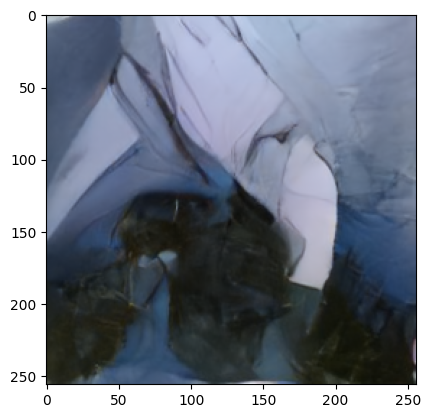

In [34]:
#generate images
x = torch.randn(1, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):
    
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

In [ ]:
#saving model
image_pipe.save_pretrained("butterfly-celebrity-abomination-model").to(device)


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


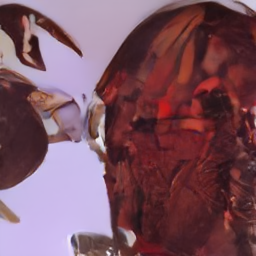

In [5]:
#load from directory
demo_pipe = DDPMPipeline.from_pretrained("./butterfly-celebrity-abomination-model", ).to(device)
images = demo_pipe(num_inference_steps=40).images
images[0]

In [7]:
#push to hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

#set up repo and upload file
model_name = "ddpm-butterfly-celebrity-abomination-model"
local_folder_name = ("butterfly-celebrity-abomination-model")

description = "testing fintune"
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)


HfHubHTTPError: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-689895f1-5d0d9eb575df36df2458d7db;121d80dd-5eca-4a5a-908e-7dc3329b9f1f)

You already created this model repo

In [8]:
api = HfApi()

#upload all required file
api.upload_folder(folder_path=f"{local_folder_name}/scheduler", path_in_repo="", repo_id=hub_model_id)
api.upload_folder(folder_path=f"{local_folder_name}/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj=f"{local_folder_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

diffusion_pytorch_model.safetensors: 100%|██████████| 455M/455M [00:35<00:00, 12.6MB/s] 


CommitInfo(commit_url='https://huggingface.co/teohyc/ddpm-butterfly-celebrity-abomination-model/commit/0d409ef71533a0cd84c5305e5d087e03ed8396dd', commit_message='Upload model_index.json with huggingface_hub', commit_description='', oid='0d409ef71533a0cd84c5305e5d087e03ed8396dd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/teohyc/ddpm-butterfly-celebrity-abomination-model', endpoint='https://huggingface.co', repo_type='model', repo_id='teohyc/ddpm-butterfly-celebrity-abomination-model'), pr_revision=None, pr_num=None)

In [9]:
#model card

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Example Fine-Tuned Model for Unit 2 of the [Diffusion Models Class ](https://github.com/huggingface/diffusion-models-class)

{description}

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

CommitInfo(commit_url='https://huggingface.co/teohyc/ddpm-butterfly-celebrity-abomination-model/commit/5d06ac04072fd12f75b97bfafe0a3973e3a3b15c', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='5d06ac04072fd12f75b97bfafe0a3973e3a3b15c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/teohyc/ddpm-butterfly-celebrity-abomination-model', endpoint='https://huggingface.co', repo_type='model', repo_id='teohyc/ddpm-butterfly-celebrity-abomination-model'), pr_revision=None, pr_num=None)